In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.2.0
	• tf.keras version: 2.3.0-tf
	• GPU device not found. Running on CPU


In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parthkhanna07","key":"480d9516d23ca1b2747ae5e0e9609b2f"}'}

In [ ]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
#import the datset
import pathlib
train_data_dir = pathlib.Path('/content/mask_data/Mask_Datasets/Train')
val_data_dir=pathlib.Path('/content/mask_data/Mask_Datasets/Validation')



In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-23 00:53:41            627  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53           3794  
madeleineferguson/farmers-markets-in-the-united-states      Farmers Markets in the United States                816KB  2020-06-10 16:41:46            163  
promptcloud/jobs-on-naukricom                               Jobs On Naukri.com                                    3MB  2020-06-15 10:51:07            171  
josehenriqueroveda/fertilizers-by-product-fao               Fert

In [ ]:
!kaggle datasets download -d ahmetfurkandemr/mask-datasets-v1

 99% 749M/754M [00:07<00:00, 82.0MB/s]
100% 754M/754M [00:07<00:00, 106MB/s] 


In [ ]:
! mkdir train
! unzip mask-datasets-v1.zip -d mask_data

Archive:  mask-datasets-v1.zip
  inflating: mask_data/Mask_Datasets/Train/Mask/1.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/10.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/100.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/101.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/102.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/103.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/104.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/105.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/106.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/107.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/108.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/109.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/11.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/110.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/111.PNG  
  inflating: mask_data/Mask_Datasets/Train/Mask/112.PNG  
  inflating: mask_data/Mask_Datasets/Train/Ma

In [ ]:
image_count = len(list(val_data_dir.glob('*/*.png')))
image_count

200

In [ ]:
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['No_mask', 'Mask'], dtype='<U7')

In [ ]:
# Performing data augmentation
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
)



In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 64
IMG_WIDTH = 64
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


In [ ]:
train_data_gen = image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode = 'binary',
                                                     classes = list(CLASS_NAMES))
                                                     

val_data_gen = image_generator.flow_from_directory(directory=str(val_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode = 'binary',
                                                     classes = list(CLASS_NAMES))


Found 750 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


In [ ]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)


In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3), activation="relu",input_shape=(64,64,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(32,(3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(128,activation="relu"),

        tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8

In [ ]:
model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=['accuracy'])

EPOCHS = 20
# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
history = model.fit_generator(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_data_gen)

Epoch 1/20
24/24 [==============================] - 31s 1s/step - loss: 0.6608 - accuracy: 0.6560 - val_loss: 0.4399 - val_accuracy: 0.8829
Epoch 2/20
24/24 [==============================] - 32s 1s/step - loss: 0.3379 - accuracy: 0.8680 - val_loss: 0.1880 - val_accuracy: 0.9400
Epoch 3/20
24/24 [==============================] - 32s 1s/step - loss: 0.1971 - accuracy: 0.9320 - val_loss: 0.1300 - val_accuracy: 0.9457
Epoch 4/20
24/24 [==============================] - 32s 1s/step - loss: 0.1471 - accuracy: 0.9507 - val_loss: 0.0999 - val_accuracy: 0.9714
Epoch 5/20
24/24 [==============================] - 32s 1s/step - loss: 0.1533 - accuracy: 0.9493 - val_loss: 0.0986 - val_accuracy: 0.9543
Epoch 6/20
24/24 [==============================] - 31s 1s/step - loss: 0.1190 - accuracy: 0.9600 - val_loss: 0.0992 - val_accuracy: 0.9771
Epoch 7/20
24/24 [==============================] - 34s 1s/step - loss: 0.1430 - accuracy: 0.9467 - val_loss: 0.1827 - val_accuracy: 0.9257
Epoch 8/20
24/24 [==

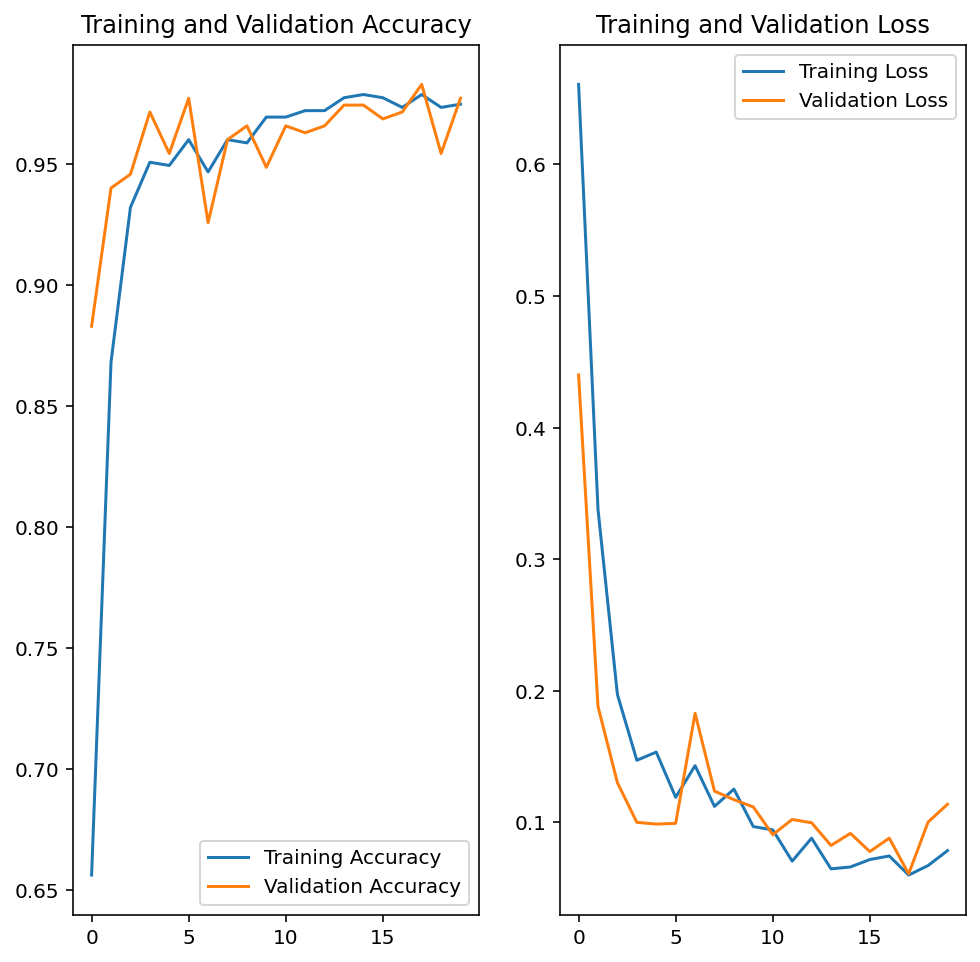

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def process_image(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (64, 64))
    image /= 255
    return image.numpy()


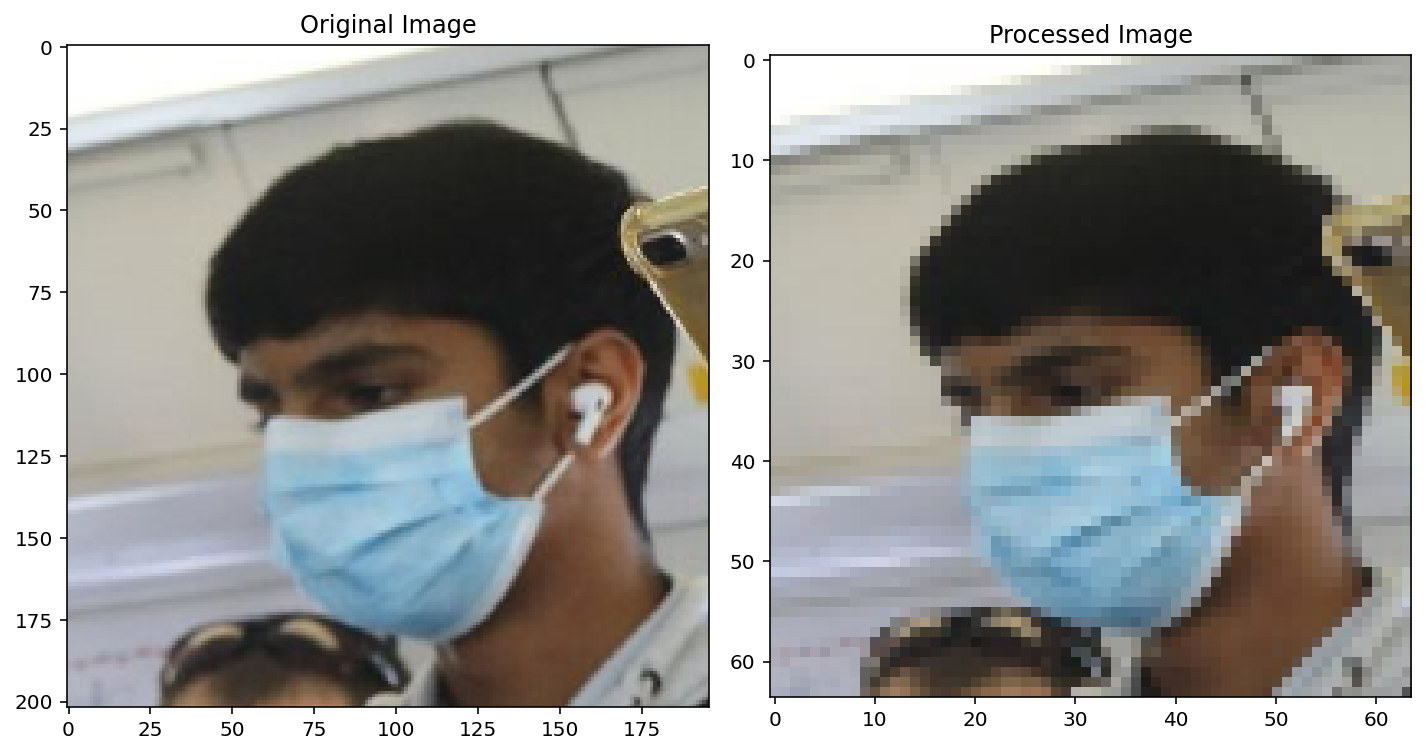

In [ ]:
from PIL import Image

image_path = '/content/mask_data/Mask_Datasets/Validation/Mask/1.PNG'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from keras.preprocessing import image

img_width, img_height = 64,64 
img = image.load_img('/content/mask_data/Mask_Datasets/Validation/No_mask/16000.png', target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model.predict(img)

array([[0.]], dtype=float32)

In [ ]:
import time
t = time.time()

saved_keras_model_filepath = './{}.h5'.format(int(t))

model.save(saved_keras_model_filepath)

<IPython.core.display.Javascript object>